In [20]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

[*********************100%***********************]  1 of 1 completed


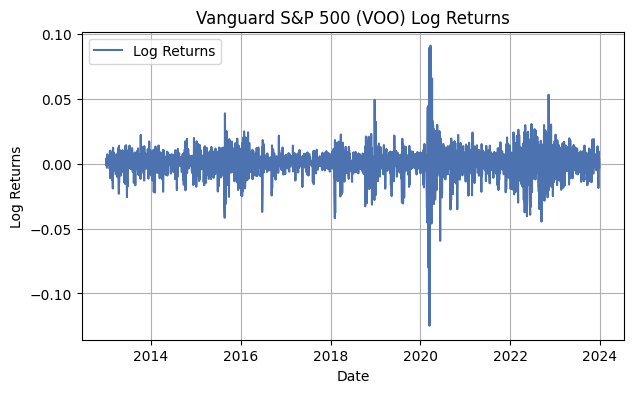

In [21]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

etf_data = yf.download('VOO', start=start_date, end=end_date)
etf_data['Returns'] = np.log(etf_data['Close'] / etf_data['Close'].shift(1))
etf_data = etf_data.dropna()
etf_data.to_csv("./Data/VOO_data.csv")

def plot_log_returns(etf_data):
    plt.figure(figsize=(7,4))
    plt.plot(etf_data.index, etf_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(etf_data)

c:\Users\chana\OneDrive\Documents\University of Liverpool\Dissertation\IT_Artifact\Black_Litterman_Risk_Parity_Portfolio_Optimisation\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 2767
Model:               MarkovRegression   Log Likelihood                9207.292
Date:                Wed, 27 Nov 2024   AIC                         -18402.584
Time:                        17:51:56   BIC                         -18367.031
Sample:                             0   HQIC                        -18389.743
                               - 2767                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.827      0.000       0.001       0.001
sigma2       3.22e-05   1.73e-06     18.632      0.0

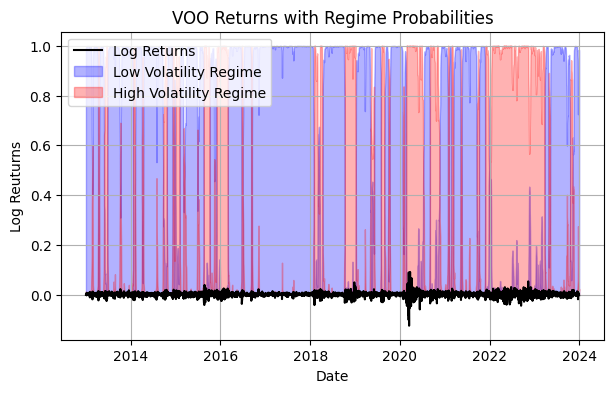

In [22]:
def fit_markov_regression(etf_data, k_regimes=2, switching_variance=True):
    model = MarkovRegression(etf_data['Returns'], k_regimes=k_regimes, switching_variance=switching_variance)
    results = model.fit()
    print(results.summary())
    
    return results, results.summary()

results, summary = fit_markov_regression(etf_data)

# To visalise when the market is in bull/bear periods. 
# Can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(etf_data):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(etf_data. index, etf_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(etf_data)

In [23]:
etf_data['Regime_0_Prob'] = results.smoothed_marginal_probabilities[0]
etf_data['Regime_1_Prob'] = results.smoothed_marginal_probabilities[1]

# Get individual asset data
asset_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
asset_returns = np.log(asset_data / asset_data.shift(1)).dropna()

etf_data.index = etf_data.index.tz_localize(None)
asset_returns.index = asset_returns.index.tz_localize(None)

# Align regime probabilities with asset_returns
aligned_probs = etf_data[['Regime_0_Prob', 'Regime_1_Prob']].reindex(asset_returns.index, method='ffill').dropna()

# Regime-specific covariance matrices
regime_0_data = asset_returns[aligned_probs['Regime_0_Prob'] > 0.5]
regime_1_data = asset_returns[aligned_probs['Regime_1_Prob'] > 0.5]

regime_0_cov = regime_0_data.cov()
regime_1_cov = regime_1_data.cov()

# Combine regime-specific covariance matrices dynamically based on probabilities
def get_dynamic_cov_matrix(aligned_probs, regime_0_cov, regime_1_cov):
    return (
        aligned_probs['Regime_0_Prob'].values[:, None, None] * regime_0_cov.values +
        aligned_probs['Regime_1_Prob'].values[:, None, None] * regime_1_cov.values
    )

dynamic_cov_matrices = get_dynamic_cov_matrix(aligned_probs, regime_0_cov, regime_1_cov)

# Use the average covariance matrix as proxy for the BL
average_dynamic_cov = np.mean(dynamic_cov_matrices, axis=0)
average_dynamic_cov = pd.DataFrame(average_dynamic_cov, index=tickers, columns=tickers)

# Calculate Market Implied Returns (Priors)
market_caps = asset_data.iloc[-1] * 1e6  # Assume market caps proportional to prices

C:\Users\chana\AppData\Local\Temp\ipykernel_16172\2466162407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_data['Regime_0_Prob'] = results.smoothed_marginal_probabilities[0]
C:\Users\chana\AppData\Local\Temp\ipykernel_16172\2466162407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_data['Regime_1_Prob'] = results.smoothed_marginal_probabilities[1]
[*********************100%***********************]  7 of 7 completed


<Axes: >

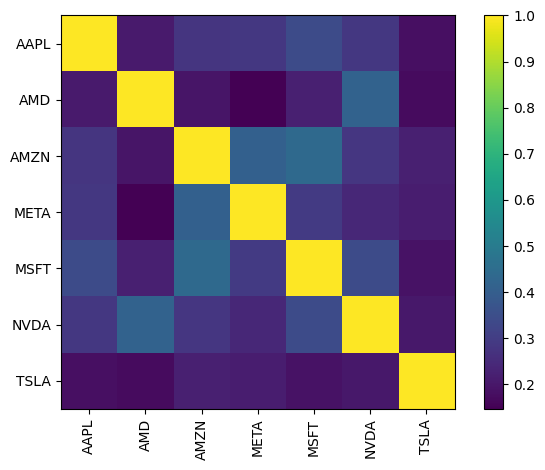

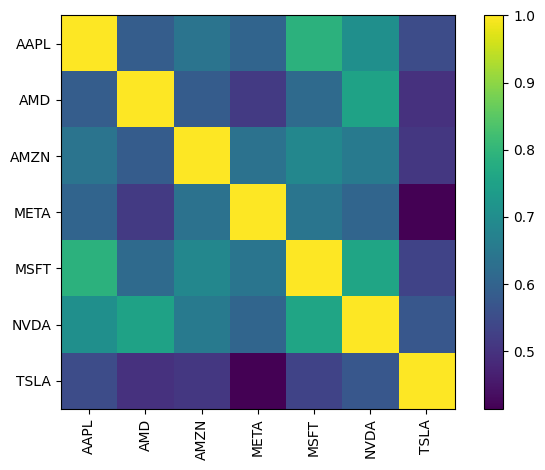

In [24]:
plotting.plot_covariance(regime_0_cov, plot_correlation=True) # low volatility
plotting.plot_covariance(regime_1_cov, plot_correlation=True) # high volatility

c:\Users\chana\OneDrive\Documents\University of Liverpool\Dissertation\IT_Artifact\Black_Litterman_Risk_Parity_Portfolio_Optimisation\env\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


<Axes: ylabel='Ticker'>

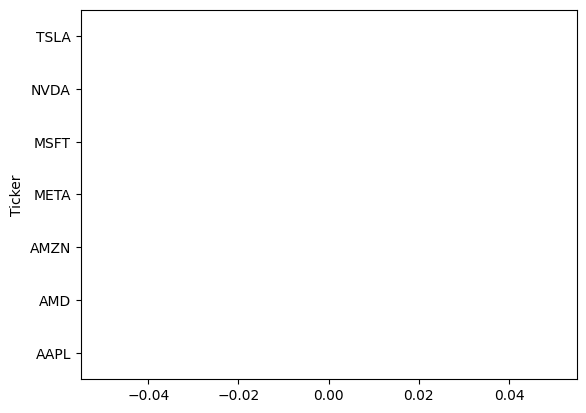

In [25]:
markov_delta = black_litterman.market_implied_risk_aversion(etf_data['Returns'])
markov_prior = black_litterman.market_implied_prior_returns(market_caps, markov_delta, risk_models.sample_cov(asset_returns))

markov_prior.plot.barh()

In [26]:
markov_view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07}
markov_view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7]

# Markov posterior returns
# with the average dynamic covariance matrix
markov_bl = BlackLittermanModel(
    average_dynamic_cov,
    pi=markov_prior,
    absolute_views=markov_view_dict,
    view_confidences=markov_view_confidences,
    omega="idzorek",
)

markov_bl_returns = markov_bl.bl_returns()
markov_bl_returns

TSLA   NaN
NVDA   NaN
AMZN   NaN
META   NaN
MSFT   NaN
AAPL   NaN
AMD    NaN
dtype: float64

In [27]:
markov_returns_df = pd.DataFrame([markov_prior, markov_bl_returns, pd.Series(markov_view_dict)], index=["Prior", "Posterior", "Views"]).T
markov_returns_df

,Prior,Posterior,Views
AAPL,NaN,NaN,0.05
AMD,NaN,NaN,0.07
AMZN,NaN,NaN,0.03
META,NaN,NaN,0.02
MSFT,NaN,NaN,0.04
NVDA,NaN,NaN,0.08
TSLA,NaN,NaN,0.04


<Axes: >

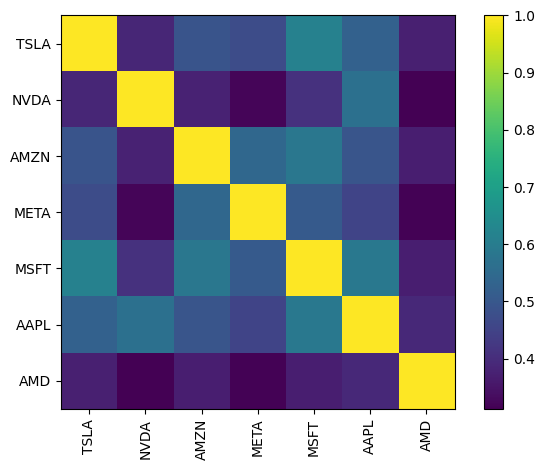

In [29]:
markov_posterior_cov = markov_bl.bl_cov()
plotting.plot_covariance(markov_posterior_cov, plot_correlation=True)

In [38]:
# Markov-switching-adjusted frontier and cleaned weights
markov_ef = EfficientFrontier(markov_bl_returns, markov_posterior_cov)
markov_max_sharpe = markov_ef.min_volatility()  # Change to ef.max_sharpe()
markov_cleaned_weights = markov_ef.clean_weights()
markov_cleaned_weights

OrderedDict([('TSLA', 0.35567),
             ('NVDA', 0.0),
             ('AMZN', 0.16463),
             ('META', 0.04635),
             ('MSFT', 0.43336),
             ('AAPL', 0.0),
             ('AMD', 0.0)])

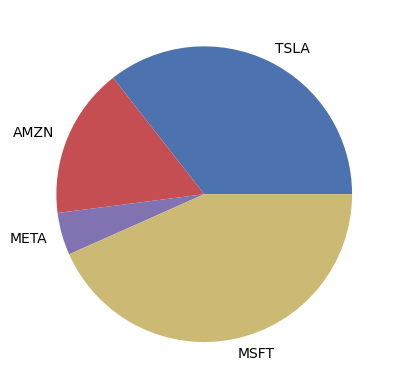

In [36]:
model_3_allocations = pd.Series(markov_cleaned_weights).plot.pie()

In [35]:
markov_ef.portfolio_performance(verbose=True)

Expected annual return: nan%
Annual volatility: 1.5%
Sharpe Ratio: nan


(nan, 0.015471658015037778, nan)